Alunos:

*   Andréa Fonseca
*   Fábio Cardoso
*   Eduardo Leite



In [ ]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-08-18 20:48:58--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  37.6MB/s    in 2.8s    

2024-08-18 20:49:01 (37.6 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [ ]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # kernel de 5
        self.conv2 = nn.Conv2d(6, 12, 5) # kernel de 5
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # inicializa os pesos usando o metodo xavier (normaliza os pesos usando o 2/(fan in + fan out))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
model = CNN(
    initialize_weights=True,
    dropout=0.2 # cada neurônio tem 20% de chance de ser desativado em cada passada do dado; essa desativação acontece somente durante o treinamento e é reativado no teste.
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 14.48it/s]


Epoch 1, Train Loss: 2.190, Train Accuracy: 22.50%
Epoch 1, Val Loss: 2.015, Val Accuracy: 37.80%


100%|██████████| 16/16 [00:00<00:00, 20.56it/s]


Epoch 2, Train Loss: 1.765, Train Accuracy: 38.70%
Epoch 2, Val Loss: 1.320, Val Accuracy: 62.60%


100%|██████████| 16/16 [00:00<00:00, 21.31it/s]


Epoch 3, Train Loss: 1.112, Train Accuracy: 62.90%
Epoch 3, Val Loss: 0.795, Val Accuracy: 75.20%


100%|██████████| 16/16 [00:00<00:00, 20.74it/s]


Epoch 4, Train Loss: 0.748, Train Accuracy: 73.10%
Epoch 4, Val Loss: 0.590, Val Accuracy: 83.00%


100%|██████████| 16/16 [00:00<00:00, 20.74it/s]


Epoch 5, Train Loss: 0.545, Train Accuracy: 81.20%
Epoch 5, Val Loss: 0.483, Val Accuracy: 84.40%
Treinamento concluído


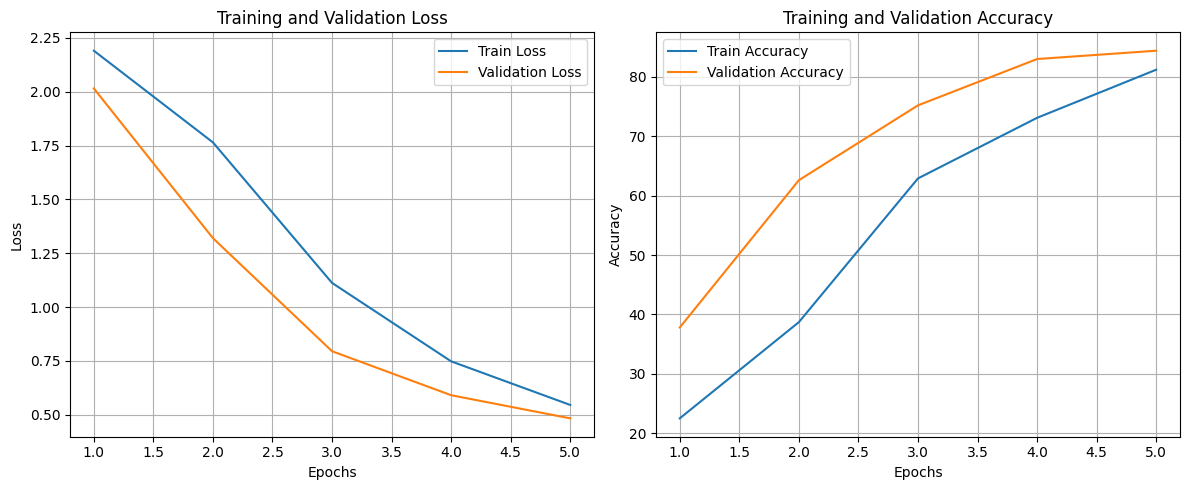

In [ ]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model, testloader)

Acurácia da rede na base de teste: 87.60%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_filters_conv1=6, num_filters_conv2=12, num_neurons=64, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters_conv1, 5) # kernel de 5
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, 5) # kernel de 5
        self.fc1 = nn.Linear(num_filters_conv2 * 4 * 4, num_neurons)
        self.fc2 = nn.Linear(num_neurons, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # inicializa os pesos usando o metodo xavier (normaliza os pesos usando o 2/(fan in + fan out))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
model_1 = CNN(num_filters_conv1=6, num_filters_conv2=12)
model_2 = CNN(num_filters_conv1=6, num_filters_conv2=16)
model_3 = CNN(num_filters_conv1=8, num_filters_conv2=12)
model_4 = CNN(num_filters_conv1=8, num_filters_conv2=16)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)
optimizer_3 = optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9)
optimizer_4 = optim.SGD(model_4.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Modelo 1 (6 e 12)
history_1 = train_model(
    model=model_1,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer_1
)

100%|██████████| 16/16 [00:00<00:00, 20.36it/s]


Epoch 1, Train Loss: 2.308, Train Accuracy: 15.30%
Epoch 1, Val Loss: 2.250, Val Accuracy: 20.00%


100%|██████████| 16/16 [00:00<00:00, 21.07it/s]


Epoch 2, Train Loss: 2.153, Train Accuracy: 26.80%
Epoch 2, Val Loss: 1.953, Val Accuracy: 47.00%


100%|██████████| 16/16 [00:00<00:00, 21.40it/s]


Epoch 3, Train Loss: 1.634, Train Accuracy: 48.30%
Epoch 3, Val Loss: 1.036, Val Accuracy: 69.40%


100%|██████████| 16/16 [00:00<00:00, 21.74it/s]


Epoch 4, Train Loss: 0.962, Train Accuracy: 66.50%
Epoch 4, Val Loss: 0.563, Val Accuracy: 82.80%


100%|██████████| 16/16 [00:00<00:00, 20.90it/s]


Epoch 5, Train Loss: 0.618, Train Accuracy: 79.20%
Epoch 5, Val Loss: 0.493, Val Accuracy: 84.20%
Treinamento concluído


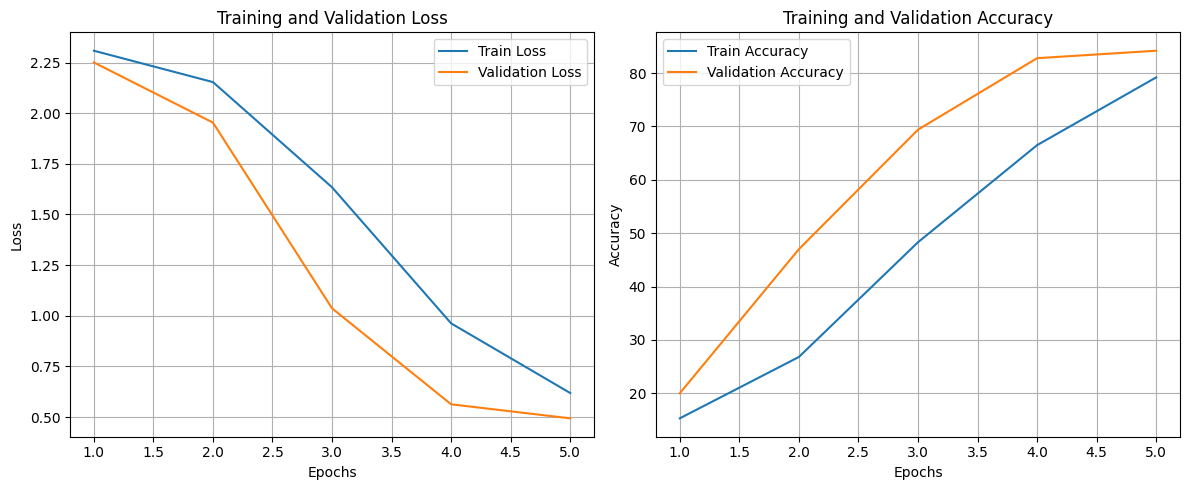

In [ ]:
epochs = range(1, len(history_1['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history_1['train_losses'], label='Train Loss')
plt.plot(epochs, history_1['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history_1['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history_1['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model_1, testloader)

Acurácia da rede na base de teste: 85.80%


In [ ]:
# Modelo 2 (6 e 16)
history_2 = train_model(
    model=model_2,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer_2
)

100%|██████████| 16/16 [00:00<00:00, 20.43it/s]


Epoch 1, Train Loss: 2.281, Train Accuracy: 15.50%
Epoch 1, Val Loss: 2.200, Val Accuracy: 27.20%


100%|██████████| 16/16 [00:00<00:00, 21.54it/s]


Epoch 2, Train Loss: 2.040, Train Accuracy: 36.20%
Epoch 2, Val Loss: 1.751, Val Accuracy: 45.80%


100%|██████████| 16/16 [00:00<00:00, 20.79it/s]


Epoch 3, Train Loss: 1.434, Train Accuracy: 53.90%
Epoch 3, Val Loss: 0.941, Val Accuracy: 69.00%


100%|██████████| 16/16 [00:00<00:00, 21.95it/s]


Epoch 4, Train Loss: 0.835, Train Accuracy: 71.90%
Epoch 4, Val Loss: 0.634, Val Accuracy: 79.80%


100%|██████████| 16/16 [00:00<00:00, 21.39it/s]


Epoch 5, Train Loss: 0.658, Train Accuracy: 77.70%
Epoch 5, Val Loss: 0.448, Val Accuracy: 87.20%
Treinamento concluído


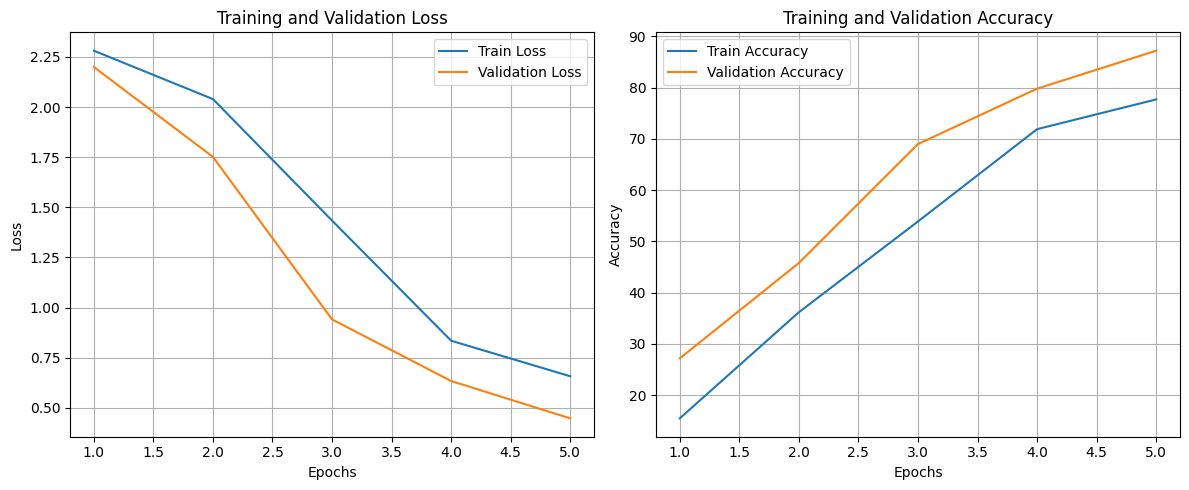

In [ ]:
epochs = range(1, len(history_2['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history_2['train_losses'], label='Train Loss')
plt.plot(epochs, history_2['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history_2['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history_2['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model_2, testloader)

Acurácia da rede na base de teste: 84.80%


In [ ]:
history_3 = train_model(
    model=model_3,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer_3
)

100%|██████████| 16/16 [00:00<00:00, 20.96it/s]


Epoch 1, Train Loss: 2.246, Train Accuracy: 17.10%
Epoch 1, Val Loss: 2.103, Val Accuracy: 33.80%


100%|██████████| 16/16 [00:00<00:00, 21.18it/s]


Epoch 2, Train Loss: 1.844, Train Accuracy: 41.10%
Epoch 2, Val Loss: 1.314, Val Accuracy: 62.80%


100%|██████████| 16/16 [00:00<00:00, 21.35it/s]


Epoch 3, Train Loss: 1.100, Train Accuracy: 63.10%
Epoch 3, Val Loss: 0.705, Val Accuracy: 77.00%


100%|██████████| 16/16 [00:00<00:00, 16.38it/s]


Epoch 4, Train Loss: 0.705, Train Accuracy: 77.60%
Epoch 4, Val Loss: 0.497, Val Accuracy: 83.00%


100%|██████████| 16/16 [00:01<00:00, 14.41it/s]


Epoch 5, Train Loss: 0.520, Train Accuracy: 82.60%
Epoch 5, Val Loss: 0.444, Val Accuracy: 86.20%
Treinamento concluído


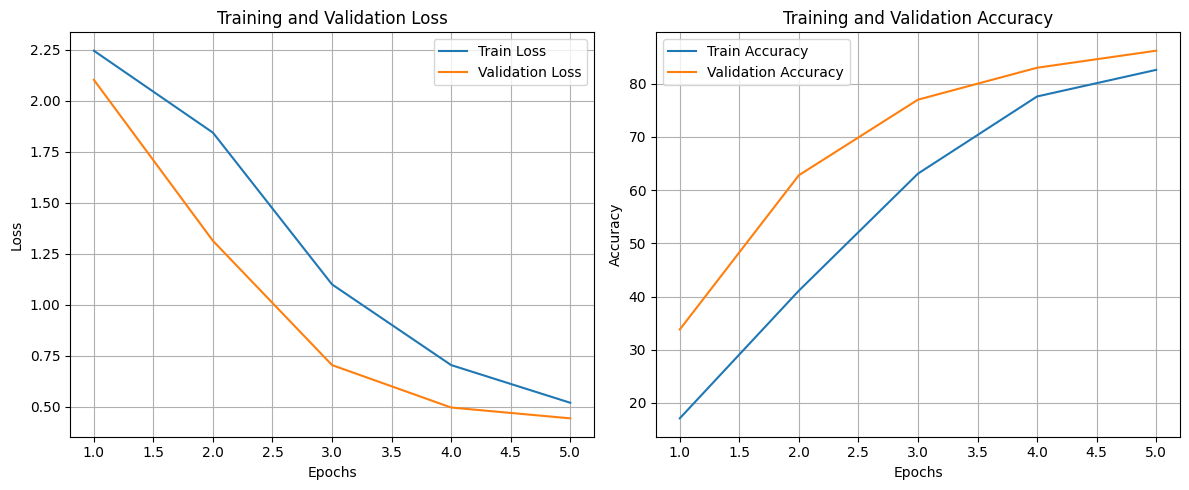

In [ ]:
epochs = range(1, len(history_3['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history_3['train_losses'], label='Train Loss')
plt.plot(epochs, history_3['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history_3['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history_3['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model_3, testloader)

Acurácia da rede na base de teste: 89.40%


In [ ]:
history_4 = train_model(
    model=model_4,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer_4
)

100%|██████████| 16/16 [00:00<00:00, 20.54it/s]


Epoch 1, Train Loss: 2.262, Train Accuracy: 16.00%
Epoch 1, Val Loss: 2.118, Val Accuracy: 41.40%


100%|██████████| 16/16 [00:00<00:00, 20.03it/s]


Epoch 2, Train Loss: 1.893, Train Accuracy: 43.40%
Epoch 2, Val Loss: 1.376, Val Accuracy: 64.40%


100%|██████████| 16/16 [00:01<00:00, 14.72it/s]


Epoch 3, Train Loss: 1.098, Train Accuracy: 64.80%
Epoch 3, Val Loss: 0.674, Val Accuracy: 78.40%


100%|██████████| 16/16 [00:01<00:00, 14.45it/s]


Epoch 4, Train Loss: 0.649, Train Accuracy: 79.20%
Epoch 4, Val Loss: 0.503, Val Accuracy: 83.20%


100%|██████████| 16/16 [00:01<00:00, 14.45it/s]


Epoch 5, Train Loss: 0.467, Train Accuracy: 85.50%
Epoch 5, Val Loss: 0.405, Val Accuracy: 88.20%
Treinamento concluído


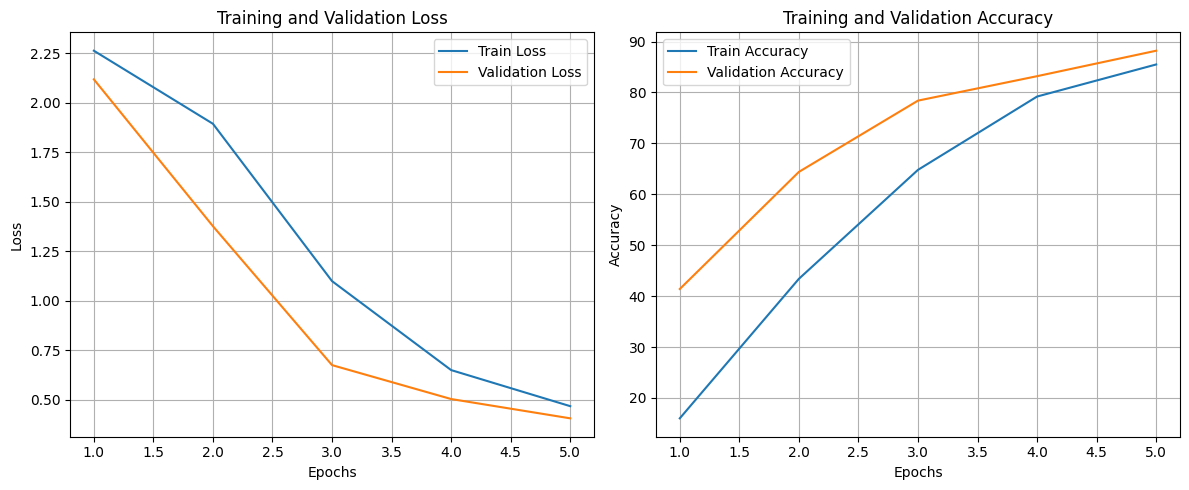

In [ ]:
epochs = range(1, len(history_4['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history_4['train_losses'], label='Train Loss')
plt.plot(epochs, history_4['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history_4['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history_4['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model_4, testloader)

Acurácia da rede na base de teste: 90.40%


Os modelos com melhor desempenhoo foram os de combinação 8 e 12 e 8 e 16; ambos com maior quantidade de parâmetros em conv1.

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

O melhor valor é aquele com menor quantidade de neurônios na camada fully connected, capaz de manter a maior acurácia.

Nos modelos abaixo, o melhor número foi 78, com desempenho de 89,60% de acurácia.

In [ ]:
for i in range(5):
     num_neurons = np.random.randint(10, 100)
     model = CNN(num_neurons=num_neurons)
     criterion = nn.CrossEntropyLoss()
     optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
     history = train_model(model, trainloader, valloader, criterion, optimizer)

     print(f'Número de neurônios na camada fully connected: {num_neurons}')
     test_model(model, testloader)
     print()

100%|██████████| 16/16 [00:01<00:00, 13.13it/s]


Epoch 1, Train Loss: 2.256, Train Accuracy: 15.10%
Epoch 1, Val Loss: 2.087, Val Accuracy: 40.00%


100%|██████████| 16/16 [00:00<00:00, 20.51it/s]


Epoch 2, Train Loss: 1.750, Train Accuracy: 47.70%
Epoch 2, Val Loss: 1.310, Val Accuracy: 57.00%


100%|██████████| 16/16 [00:00<00:00, 21.47it/s]


Epoch 3, Train Loss: 0.990, Train Accuracy: 66.20%
Epoch 3, Val Loss: 0.708, Val Accuracy: 76.60%


100%|██████████| 16/16 [00:00<00:00, 21.15it/s]


Epoch 4, Train Loss: 0.618, Train Accuracy: 79.70%
Epoch 4, Val Loss: 0.545, Val Accuracy: 83.00%


100%|██████████| 16/16 [00:00<00:00, 20.85it/s]


Epoch 5, Train Loss: 0.450, Train Accuracy: 85.60%
Epoch 5, Val Loss: 0.422, Val Accuracy: 86.80%
Treinamento concluído
Número de neurônios na camada fully connected: 78
Acurácia da rede na base de teste: 89.60%



100%|██████████| 16/16 [00:00<00:00, 20.85it/s]


Epoch 1, Train Loss: 2.251, Train Accuracy: 17.40%
Epoch 1, Val Loss: 2.066, Val Accuracy: 44.20%


100%|██████████| 16/16 [00:00<00:00, 20.28it/s]


Epoch 2, Train Loss: 1.690, Train Accuracy: 46.10%
Epoch 2, Val Loss: 1.088, Val Accuracy: 68.00%


100%|██████████| 16/16 [00:00<00:00, 20.91it/s]


Epoch 3, Train Loss: 1.006, Train Accuracy: 66.70%
Epoch 3, Val Loss: 0.638, Val Accuracy: 79.60%


100%|██████████| 16/16 [00:00<00:00, 20.51it/s]


Epoch 4, Train Loss: 0.690, Train Accuracy: 76.20%
Epoch 4, Val Loss: 0.517, Val Accuracy: 84.20%


100%|██████████| 16/16 [00:00<00:00, 17.55it/s]


Epoch 5, Train Loss: 0.502, Train Accuracy: 82.10%
Epoch 5, Val Loss: 0.438, Val Accuracy: 85.40%
Treinamento concluído
Número de neurônios na camada fully connected: 90
Acurácia da rede na base de teste: 86.60%



100%|██████████| 16/16 [00:01<00:00, 14.66it/s]


Epoch 1, Train Loss: 2.322, Train Accuracy: 12.90%
Epoch 1, Val Loss: 2.226, Val Accuracy: 21.20%


100%|██████████| 16/16 [00:01<00:00, 14.75it/s]


Epoch 2, Train Loss: 2.094, Train Accuracy: 30.80%
Epoch 2, Val Loss: 1.860, Val Accuracy: 40.40%


100%|██████████| 16/16 [00:00<00:00, 20.92it/s]


Epoch 3, Train Loss: 1.535, Train Accuracy: 50.40%
Epoch 3, Val Loss: 1.104, Val Accuracy: 64.60%


100%|██████████| 16/16 [00:00<00:00, 20.37it/s]


Epoch 4, Train Loss: 0.961, Train Accuracy: 68.10%
Epoch 4, Val Loss: 0.594, Val Accuracy: 81.60%


100%|██████████| 16/16 [00:00<00:00, 20.36it/s]


Epoch 5, Train Loss: 0.706, Train Accuracy: 77.30%
Epoch 5, Val Loss: 0.527, Val Accuracy: 84.80%
Treinamento concluído
Número de neurônios na camada fully connected: 61
Acurácia da rede na base de teste: 84.20%



100%|██████████| 16/16 [00:00<00:00, 21.20it/s]


Epoch 1, Train Loss: 2.296, Train Accuracy: 11.70%
Epoch 1, Val Loss: 2.214, Val Accuracy: 25.80%


100%|██████████| 16/16 [00:00<00:00, 21.11it/s]


Epoch 2, Train Loss: 2.132, Train Accuracy: 24.50%
Epoch 2, Val Loss: 1.985, Val Accuracy: 32.60%


100%|██████████| 16/16 [00:00<00:00, 21.15it/s]


Epoch 3, Train Loss: 1.832, Train Accuracy: 34.10%
Epoch 3, Val Loss: 1.532, Val Accuracy: 48.00%


100%|██████████| 16/16 [00:00<00:00, 21.55it/s]


Epoch 4, Train Loss: 1.447, Train Accuracy: 48.60%
Epoch 4, Val Loss: 1.123, Val Accuracy: 64.80%


100%|██████████| 16/16 [00:00<00:00, 20.57it/s]


Epoch 5, Train Loss: 1.109, Train Accuracy: 61.60%
Epoch 5, Val Loss: 0.776, Val Accuracy: 77.20%
Treinamento concluído
Número de neurônios na camada fully connected: 20
Acurácia da rede na base de teste: 77.00%



100%|██████████| 16/16 [00:00<00:00, 17.81it/s]


Epoch 1, Train Loss: 2.277, Train Accuracy: 14.20%
Epoch 1, Val Loss: 2.190, Val Accuracy: 13.60%


100%|██████████| 16/16 [00:01<00:00, 15.70it/s]


Epoch 2, Train Loss: 1.987, Train Accuracy: 31.90%
Epoch 2, Val Loss: 1.694, Val Accuracy: 46.40%


100%|██████████| 16/16 [00:01<00:00, 14.00it/s]


Epoch 3, Train Loss: 1.443, Train Accuracy: 50.50%
Epoch 3, Val Loss: 0.968, Val Accuracy: 74.20%


100%|██████████| 16/16 [00:00<00:00, 16.26it/s]


Epoch 4, Train Loss: 0.953, Train Accuracy: 69.80%
Epoch 4, Val Loss: 0.615, Val Accuracy: 80.60%


100%|██████████| 16/16 [00:00<00:00, 20.95it/s]


Epoch 5, Train Loss: 0.746, Train Accuracy: 74.30%
Epoch 5, Val Loss: 0.514, Val Accuracy: 85.60%
Treinamento concluído
Número de neurônios na camada fully connected: 31
Acurácia da rede na base de teste: 85.60%

